## Pandas analysis

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a couple of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to $\frac{25}{30}$ ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every 'x' BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If you didn't download it yet, please get the relevant file now!
#!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ~/data/

#!wget doesn't work on my machine so I'm using urllib.request to import the data into a dataframe.

1\. Create a Pandas DataFrame reading N rows of the 'data_000637.txt' dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k.

2\. Find out the number of BX in a ORBIT (the value 'x').

3\. Find out how much the data taking lasted. You can either make an estimate based on the fraction of the measurements (rows) you read, or perform this check precisely by reading out the whole dataset.

4\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information).

5\. Replace the values (all 1) of the HEAD column randomly with 0 or 1.

6\. Create a new DataFrame that contains only the rows with HEAD=1.

7\. Make two occupancy plots (one for each FPGA), i.e. plot the number of counts per TDC channel

8\. Use the groupby method to find out the noisy channels, i.e. the TDC channels with most counts (say the top 3)

9\. Count the number of unique orbits. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139

## 1.

In [2]:
import urllib.request
import pandas as pd

url = 'https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt?dl=1'
#I am just loading the whole file into the dataframe.
with urllib.request.urlopen(url) as data_file:
    df = pd.read_csv(data_file, sep = ",")

## 2.

In [3]:
# Since it seems that it isn't quite clear when ORBIT_CNT changes based on just looking at the dataframe, I'm taking the number of BX that increase ORBIT_CNT to just be the maximum value in BX_COUNTER+1 (like 1 hour is 60 minutes but the clock only shows up to 59)

BX_est = df["BX_COUNTER"].max()+1
print(BX_est)

# We'll also go ahead and define the max TDC_MEAS, which I am guessing is 30.
TDC_max = df["TDC_MEAS"].max()+1
print(TDC_max)

3564
30


## 3.

In [4]:
# I saw that some of the points of the dataset weren't in order, so I'm trying to use maximum and minimum values of the dataset to obtain the time taken. It makes it look quite convoluted but I can't find a workaround.

time_taken = ((df["ORBIT_CNT"].max() - df["ORBIT_CNT"].min()) * (BX_est) + df["BX_COUNTER"][df["ORBIT_CNT"] == df["ORBIT_CNT"].max()].max() - df["BX_COUNTER"][df["ORBIT_CNT"] == df["ORBIT_CNT"].min()].min()) * 25 + (TDC_max - (df["TDC_MEAS"][df["BX_COUNTER"][df["ORBIT_CNT"] == df["ORBIT_CNT"].min()].min()].min()))*(25/30)

#We find by how much ORBIT_CNT increased from the first reading to the last, multiply that by the estimate BX counts between each ORBIT_CNT, then we add the last BX_COUNTER, and finally we multiply this whole number by 25 to convert to nanoseconds, and finally we add TDC_MEAS converted to nanoseconds as well.


print("Data collection lasted about {:.10f} seconds".format(time_taken*10**-9))

Data collection lasted about 0.9804163000 seconds


## 4.

In [5]:
# Instead of going through the pain of writing something like last cell, I'll just define a couple of quantities first
TDC_min = (df["TDC_MEAS"][df["BX_COUNTER"][df["ORBIT_CNT"] == df["ORBIT_CNT"].min()].min()].min())
BX_min = df["BX_COUNTER"][df["ORBIT_CNT"] == df["ORBIT_CNT"].min()].min()

df["time"] = ((df["ORBIT_CNT"] - df["ORBIT_CNT"].min())*BX_est+df["BX_COUNTER"]-BX_min)*25-TDC_min*(25/30)+df["TDC_MEAS"]*(25/30)

In [6]:
# I noticed that some values were not sorted by ascending time, so this cell works to just reorder them.
df = df.sort_values("time", ascending = True)
df = df.reset_index(drop=True)
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,1,0,123,3869200167,2374,26,2.166667e+01
1,1,0,124,3869200167,2374,27,2.250000e+01
2,1,0,63,3869200167,2553,28,4.498333e+03
3,1,0,64,3869200167,2558,19,4.615833e+03
4,1,0,64,3869200167,2760,25,9.670833e+03
...,...,...,...,...,...,...,...
1310715,1,0,62,3869211171,762,14,9.804161e+08
1310716,1,0,61,3869211171,762,18,9.804161e+08
1310717,1,1,4,3869211171,763,11,9.804161e+08
1310718,1,0,64,3869211171,764,0,9.804162e+08


## 5.

In [7]:
import numpy as np
df["HEAD"] = np.random.choice([0,1],len(df))

## 6.

In [8]:
new_df = df[df["HEAD"] == 1]
new_df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS,time
0,1,0,123,3869200167,2374,26,2.166667e+01
1,1,0,124,3869200167,2374,27,2.250000e+01
2,1,0,63,3869200167,2553,28,4.498333e+03
4,1,0,64,3869200167,2760,25,9.670833e+03
5,1,0,63,3869200167,2762,4,9.703333e+03
...,...,...,...,...,...,...,...
1310714,1,0,60,3869211171,762,2,9.804161e+08
1310716,1,0,61,3869211171,762,18,9.804161e+08
1310717,1,1,4,3869211171,763,11,9.804161e+08
1310718,1,0,64,3869211171,764,0,9.804162e+08


## 7.

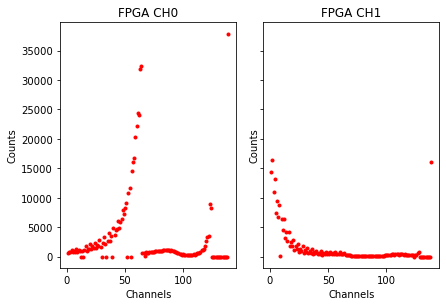

In [12]:
import matplotlib.pyplot as plt

# divide the dataframe into the two channels FPGA = 0 and FPGA = 1

df1 = new_df[new_df["FPGA"] == 0]
df2 = new_df[new_df["FPGA"] == 1]
fig, ax = plt.subplots(1,2, sharey = True)
fig.tight_layout()

x1 = np.arange(1, df1["TDC_CHANNEL"].max()+1)
y1 = np.array([len(df1[df1["TDC_CHANNEL"] == i]) for i in x1])
x2 = np.arange(1, df2["TDC_CHANNEL"].max()+1)
y2 = np.array([len(df2[df2["TDC_CHANNEL"] == i]) for i in x2])

ax[0].plot(x1, y1, 'r.')
ax[0].set_title("FPGA CH0")
ax[0].set_xlabel("Channels")
ax[0].set_ylabel("Counts")

ax[1].plot(x2, y2, 'r.')
ax[1].set_title("FPGA CH1")
ax[1].set_xlabel("Channels")
ax[1].set_ylabel("Counts")

plt.show()

## 8.

In [10]:
df.groupby("TDC_CHANNEL").TDC_CHANNEL.count().nlargest(3)

#groupby() groups the TDC_CHANNEL column by the counts using the count() method. nlargest(3) ensures we only get the three largest channels.

TDC_CHANNEL
139    108059
64      66020
63      64642
Name: TDC_CHANNEL, dtype: int64

## 9.

In [11]:
#Number of unique orbits:
unique_orbits = df["ORBIT_CNT"].unique()
print(unique_orbits)

#Number of unique orbits in TDC_CHANNEL = 139
uniques_CH139 = df["ORBIT_CNT"][df["TDC_CHANNEL"] == 139].unique()
print(uniques_CH139)

#they look similar but let's look at the length of each
print(len(unique_orbits))
print(len(uniques_CH139))

[3869200167 3869200168 3869200169 ... 3869211169 3869211170 3869211171]
[3869200167 3869200168 3869200169 ... 3869211169 3869211170 3869211171]
11001
10976
